# Notebook de Paul

Ici, Paul peut faire ses tests pour les parties du sujet dont il s'occupe.

Bon courage Paul :)

## Import necessary libraries

In [229]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import shutil as su
import random as rd
import cv2
import math

## Load data

In [54]:
%%bash
mkdir -p tmp_data
rm -rf tmp_data/*
mkdir -p tmp_data/train_set
mkdir -p tmp_data/test_set

## Separate training dataset

In [55]:
def separate_data(path, nb_elements=1):
    """
    Separate given data in `path` in two sets with `nb_elements` per class for test

    Parameters
    ----------
    path: str
        Path to directory where dataset files are stored.

    nb_elements: integer
        Defines the number of test images taken in each class of the dataset
    """
    assert os.path.exists(path)
    labels_path = os.path.join(path, "labels.txt")
    images_path = path
    test_path = 'tmp_data/test_set'
    train_path = 'tmp_data/train_set'

    labels = np.empty((0, 1))
    names = np.empty((0, 1))
    with open(labels_path) as f:
        for current_label in f:
            if current_label == "\n":
                continue
            label, name = current_label.split(": ")
            labels = np.append(labels, label)
            names = np.append(names, name)

    for label in labels:
        pre_label = 'img_' + label + '_'
        curr_test_path = os.path.join(test_path, label)
        curr_train_path = os.path.join(train_path, label)
        os.makedirs(curr_test_path, exist_ok=True)
        os.makedirs(curr_train_path, exist_ok=True)

        current_path = os.path.join(images_path, label)
        datas = os.listdir(current_path)
        rd.shuffle(datas)

        count = 0
        for data in datas:
            data_path = os.path.join(current_path, data)
            if count < nb_elements:
                su.copyfile(data_path, os.path.join(curr_test_path, pre_label + str(count) + '.png'))
            else:
                su.copyfile(data_path, os.path.join(curr_train_path, pre_label + str(count - nb_elements) + '.png'))
            count += 1

    return labels, names

In [56]:
ref = separate_data('ressources/train', 1)

## Get separated datasets

In [57]:
def get_datasets(kind='train'):
    """
    Returns `kind` set and their label

    Parameters
    ----------
    kind: str (train or test)
        Type of dataset we want to get
    """
    assert kind == 'train' or kind == 'test'
    dataset_path = 'tmp_data/train_set' if kind == 'train' else 'tmp_data/test_set'
    assert os.path.exists(dataset_path)
    
    images = []
    labels = []
    dirs = os.listdir(dataset_path)

    for folder in dirs : 
        curr_path = os.path.join(dataset_path, folder)
        datas = os.listdir(curr_path)
        for data in datas:
            data_path = os.path.join(curr_path, data)
            img = cv2.imread(data_path);
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB);
            images.append(img)
            labels.append(folder)
    
    return labels, images

In [58]:
train_labels, train_images = get_datasets('train')
test_labels, test_images = get_datasets('test')

## Shuffle datasets

In [59]:
def shuffle_set(labels, images):
    """
    Shuffles equally labels and images

    Parameters
    ----------
    labels: [str]
        Dataset's labels
        
    images: [image]
        Dataset's images
    """
    assert len(labels) == len(images)
    shuffle_index = np.arange(len(labels))
    np.random.shuffle(shuffle_index)
    new_labels = np.array(labels)
    new_images = np.array(images, dtype=object)
    
    for ii in range(shuffle_index.size):
        new_labels[ii] = labels[shuffle_index[ii]]
        new_images[ii] = images[shuffle_index[ii]]
        
    return new_labels, new_images

In [60]:
train_labels, train_images = shuffle_set(train_labels, train_images)
test_labels, test_images = shuffle_set(test_labels, test_images)

## Print train example

11
['tâches\n']


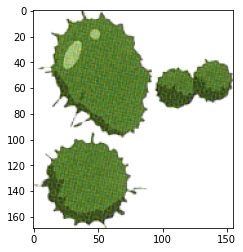

In [61]:
print(train_labels[0])
plt.imshow(train_images[0])
print(ref[1][np.where(ref[0] == train_labels[0])])

## Print test example

25
['feu\n']


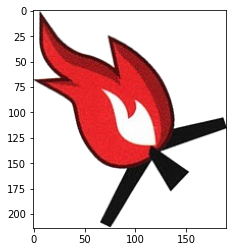

In [62]:
print(test_labels[0])
plt.imshow(test_images[0])
print(ref[1][np.where(ref[0] == test_labels[0])])

## Summary

If you executed all of the above, you defined the following variables:

```python
ref # couple:
    ref[0] # labels' identifiers
    ref[1] # labels

train_labels # train dataset's images' identifiers for labels

train_images # train dataset's images

test_labels # test dataset's images' identifiers for labels

test_images # test dataset's images
```

In [63]:
def find_all_labeled(label, labels):
    """
    Returns all indices of element like `label` in `labels`

    Parameters
    ----------
    label: str
        Searched label
    
    labels: [str]
        Dataset's labels
    """
    indices = []
    for i in range(labels.size):
        if labels[i] == label:
            indices.append(i)
    return indices

find_all_labeled(train_labels[0], train_labels)

[0, 51, 204, 213]

In [64]:
def grayscale(img):
    return np.dot(img[..., :3], [.299, .587, .114])

In [65]:
def inverted(img):
    img = img.copy()
    for ii in range(len(img)):
        for jj in range(len(img[0])):
            img[ii][jj] = 255 - img[ii][jj]
    
    return img

In [66]:
def raw_moment(i, j, img):
    moment = 0
    for y in range(len(img)):
        for x in range(len(img[0])):
            moment += x ** i * y ** j * img[y][x]
    return moment

In [67]:
def central_moment(i, j, img):
    avg_moment = raw_moment(0, 0, img)
    x_centroid = raw_moment(1, 0, img) / avg_moment
    y_centroid = raw_moment(0, 1, img) / avg_moment
    
    moment = 0
    for y in range(len(img)):
        for x in range(len(img[0])):
            moment += (x - x_centroid) ** i * (y - y_centroid) ** j * img[y][x]
    return moment

In [68]:
def central_moment_opt(centroid, i, j, img):
    moment = 0
    for y in range(len(img)):
        for x in range(len(img[0])):
            moment += (x - centroid[0]) ** i * (y - centroid[1]) ** j * img[y][x]
    return moment

In [69]:
def scale_invariant_moment(i, j, img):
    assert i + j >= 2
    return central_moment(i, j, img) / central_moment(0, 0, img) ** (1 + (i + j) / 2)

In [70]:
def scale_invariant_moment_opt(centroid, c0, i, j, img):
    assert i + j >= 2
    return central_moment_opt(centroid, i, j, img) / c0 ** (1 + (i + j) / 2)

In [71]:
def hu_moments_opt(img):
    img_gray = inverted(grayscale(img))
    
    avg = raw_moment(0, 0, img_gray)
    centroid = (raw_moment(1, 0, img_gray) / avg, raw_moment(0, 1, img_gray) / avg)
    
    c0 = central_moment_opt(centroid, 0, 0, img_gray)
    
    nu20 = scale_invariant_moment_opt(centroid, c0, 2, 0, img_gray)
    nu11 = scale_invariant_moment_opt(centroid, c0, 1, 1, img_gray)
    nu02 = scale_invariant_moment_opt(centroid, c0, 0, 2, img_gray)
    nu30 = scale_invariant_moment_opt(centroid, c0, 3, 0, img_gray)
    nu21 = scale_invariant_moment_opt(centroid, c0, 2, 1, img_gray)
    nu12 = scale_invariant_moment_opt(centroid, c0, 1, 2, img_gray)
    nu03 = scale_invariant_moment_opt(centroid, c0, 0, 3, img_gray)
    
    hu = np.zeros(7)
    
    t0 = nu30 + nu12;
    t1 = nu21 + nu03;

    q0 = t0 * t0
    q1 = t1 * t1;

    n4 = 4 * nu11;
    s = nu20 + nu02;
    d = nu20 - nu02;

    hu[0] = s;
    hu[1] = d * d + n4 * nu11;
    hu[3] = q0 + q1;
    hu[5] = d * (q0 - q1) + n4 * t0 * t1;

    t0 *= q0 - 3 * q1;
    t1 *= 3 * q0 - q1;

    q0 = nu30 - 3 * nu12;
    q1 = 3 * nu21 - nu03;

    hu[2] = q0 * q0 + q1 * q1;
    hu[4] = q0 * t0 + q1 * t1;
    hu[6] = q1 * t0 - q0 * t1;
    
    return hu

In [72]:
def hu_moments(img):
    img_gray = inverted(grayscale(img))
    
    nu20 = scale_invariant_moment(2, 0, img_gray)
    nu11 = scale_invariant_moment(1, 1, img_gray)
    nu02 = scale_invariant_moment(0, 2, img_gray)
    nu30 = scale_invariant_moment(3, 0, img_gray)
    nu21 = scale_invariant_moment(2, 1, img_gray)
    nu12 = scale_invariant_moment(1, 2, img_gray)
    nu03 = scale_invariant_moment(0, 3, img_gray)
    
    I0 = (nu20 + nu02)
    
    I1 = ((nu20 - nu02) ** 2 +
          4 * nu11 ** 2)
    
    I2 = ((nu30 - 3 * nu12) ** 2 +
          (3 * nu21 - nu03) ** 2)
    
    I3 = ((nu30 + nu12) ** 2 +
          (nu21 + nu03) ** 2)
    
    I4 = ((nu30 - 3 * nu12) * (nu30 + nu12) *
          ((nu30 + nu12) ** 2 - 3 * (nu21 + nu03) ** 2) +
          (3 * nu21 - nu03) * (nu21 + nu03) *
          (3 * (nu30 + nu12) ** 2 - (nu21 + nu03) ** 2))
    
    I5 = ((nu20 - nu02) * ((nu30 + nu12) ** 2 - (nu21 + nu03) ** 2) +
          4 * nu11 * (nu30 + nu12) * (nu21 + nu03))
    
    I6 = ((3 * nu21 - nu03) * (nu30 + nu12) *
          ((nu30 + nu12) ** 2 - 3 * (nu21 + nu03) ** 2) -
          (nu30 - 3 * nu12) * (nu21 + nu03) *
          (3 * (nu30 + nu12) ** 2 - (nu21 + nu03) ** 2))
    
    return [I0, I1, I2, I3, I4, I5, I6]

In [73]:
def compute_moments_diff(hu_1, hu_2):
    diff = 0
    for i in range(7):
        diff += (hu_2[i] - hu_1[i]) ** 2
        
    return math.sqrt(diff)

In [76]:
def moments_from(images):
    hu_mo = np.zeros((len(images), 7))
    for ii in range(len(images)):
        hu_mo[ii] = hu_moments_opt(images[ii])
    return hu_mo * 1e6

In [77]:
train_moments = moments_from(train_images)

In [78]:
test_moments = moments_from(test_images)

In [263]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

km = make_pipeline(StandardScaler(), SVC()).fit(train_moments, train_labels) # 86%

In [267]:
from sklearn.neighbors import KNeighborsClassifier

km = KNeighborsClassifier(n_neighbors=6).fit(train_moments, train_labels) # 56%

In [268]:
from sklearn.ensemble import RandomForestClassifier

km = RandomForestClassifier().fit(train_moments, train_labels) # 100%

In [279]:
res = km.predict(test_moments)

In [280]:
count = 0.
for ii in range(test_labels.size):
    if (test_labels[ii] != res[ii]):
        count += 1
        print(ii, test_labels[ii], '->', res[ii])

print('results:', 1 - count / test_labels.size)

results: 1.0


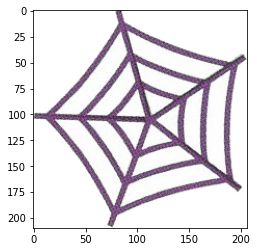

In [227]:
plt.imshow(test_images[20])

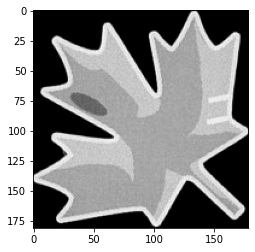

In [94]:
plt.imshow(inverted(grayscale(test_images[11])), cmap = 'gray')